In [1]:
import torch
import torch.nn as nn

In [2]:
import torch.nn as nn

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(inputSize, hiddenSize, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hiddenSize, hiddenSize*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hiddenSize*2, hiddenSize*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hiddenSize*4, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Linear(1, 28),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(28, 1),
            nn.Sigmoid())

    def forward(self, input):
        return self.main(input)

In [3]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(inputSize, hiddenSize*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hiddenSize*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(hiddenSize*4, hiddenSize*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(hiddenSize*2, hiddenSize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize),
            nn.ReLU(True),

            nn.ConvTranspose2d(hiddenSize, outputSize, 4, 2, 3, bias=False),
            nn.Tanh())

    def forward(self, input):
        return self.main(input)

In [4]:
import random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)


# Random seed
manualSeed = 7777
print('Random Seed:', manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

GPU State: cpu
Random Seed: 7777


In [6]:
# Attributes
batch_size = 50
image_size = 28
G_out_D_in = 1
G_in = 100
G_hidden = 28
D_hidden = 28

epochs = 5
lr = 0.001
beta1 = 0.5

In [7]:
# Data
from torchvision.datasets import FashionMNIST
trans = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
traindata = FashionMNIST(root='./data', transform=trans, train=True, download=True)
dataLoader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
# Weights
def weights_init(m):
    classname = m.__class__.__name__
    print('classname:', classname)

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Train
img_list = []
def train():
    # Create the generator
    netG = Generator(G_in, G_hidden, G_out_D_in).to(device)
    netG.apply(weights_init)
    print(netG)

    # Create the discriminator
    netD = Discriminator(G_out_D_in, D_hidden).to(device)
    netD.apply(weights_init)
    print(netD)

    # Loss fuG_out_D_intion
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, G_in, 1, 1, device=device)

    real_label = 1
    fake_label = 0
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    
    G_losses = []
    D_losses = []
    iters = 0
    print('Start!')

    for epoch in range(epochs):
        for i, data in enumerate(dataLoader, 0):
            # Update D network
            netD.zero_grad()
            real_cpu = data[0].to(device)
            real_cpu = real_cpu.to(torch.float32)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            label = label.to(torch.float32)
            output = netD(real_cpu).view(-1)
            output = output.to(torch.float32)

            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, G_in, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)

            errD_fake = criterion(output, label)
            errD_fake.backward()

            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            # Update G network
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, epochs, i, len(dataLoader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataLoader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()

                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    torch.save(netD, 'netD.pkl')
    torch.save(netG, 'netG.pkl')

    return G_losses, D_losses

In [10]:
# Train
img_list = []
def train():
    # Create the generator
    netG = Generator(G_in, G_hidden, G_out_D_in).to(device)
    netG.apply(weights_init)
    print(netG)

    # Create the discriminator
    netD = Discriminator(G_out_D_in, D_hidden).to(device)
    netD.apply(weights_init)
    print(netD)

    # Loss fuG_out_D_intion
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, G_in, 1, 1, device=device)

    real_label = 1
    fake_label = 0
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    
    G_losses = []
    D_losses = []
    iters = 0
    print('Start!')

    for epoch in range(epochs):
        for i, data in enumerate(dataLoader, 0):
            # Update D network
            netD.zero_grad()
            real_cpu = data[0].to(device)
            real_cpu = real_cpu.to(torch.float32)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            label = label.to(torch.float32)
            output = netD(real_cpu).view(-1)
            output = output.to(torch.float32)

            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, G_in, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)

            errD_fake = criterion(output, label)
            errD_fake.backward()

            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            # Update G network
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, epochs, i, len(dataLoader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataLoader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()

                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    torch.save(netD, 'netD.pkl')
    torch.save(netG, 'netG.pkl')

    return G_losses, D_losses

In [11]:
# Plot
def plotImage(G_losses, D_losses):
    print('Start to plot!!')
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataLoader))

    # Plot the real images
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

    # Plot the fake images from the last epoch
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

In [12]:
G_losses, D_losses = train()

classname: ConvTranspose2d
classname: BatchNorm2d
classname: ReLU
classname: ConvTranspose2d
classname: BatchNorm2d
classname: ReLU
classname: ConvTranspose2d
classname: BatchNorm2d
classname: ReLU
classname: ConvTranspose2d
classname: Tanh
classname: Sequential
classname: Generator
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 112, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(56, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(28, 1, kernel_size=(4, 4), stri

Start to plot!!


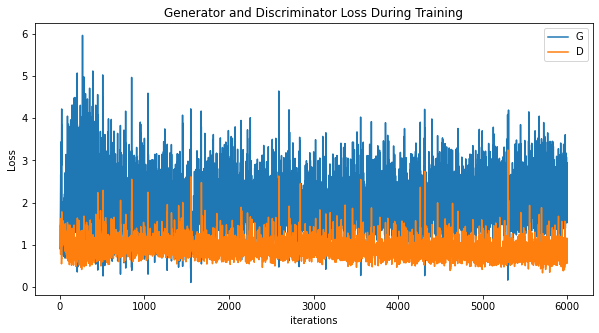

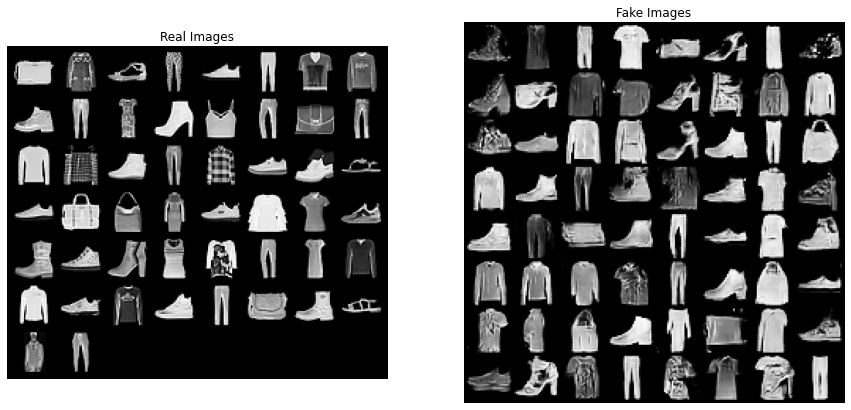

In [13]:
plotImage(G_losses, D_losses)